<a href="https://colab.research.google.com/github/kkrysw/ForkCast/blob/main/ML_for_ForkCast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

about our dataset:
6254 entries
- status: string taking on binary value 'Open' or 'Closed'. tells us whether a restaurant is open or closed. we have 4574 open and 1680 closed in the dataset.
- boro: string with the name of one of five NYC boroughs. tells us which borough a restaurant is located in
- rating: integer from 1 to 5, with 1 being the lowest rating (bad) and 5 being the highest (good).
- review_count: integer. tells us the number of customer reviews for that restaurant
- cuisine: string. tells us the type of cuisine the restaurant serves. many repetitive/redundant categories, like 'Chinese' vs 'Chinese/Korean'.
- price: integer from 1 to 4 that rates how expensivea restaurant is. 1 is the cheapest and 4 is the most expensive.
- inspection_date: a list of datetime values of when all inspections for a restaurant took place
- violation_code: a list of strings. an alphanumeric code assigned to each type of violation for each inspection
- violation_description: a list of strings. a long text for each inspection and what violations were found.
- critical_flag: a list of strings. 'Critical' if that inspection resulted in a critical violation, and 'Not Critical' or 'Not Applicable' otherwise.
- score: a list of floats representing the score for each inspection. 0 is the best score, and above 28 is bad.
- grade: a list of strings representing the grade for each inspection. if the score was 0-13, it is an A. 14-27=B, and 28+=C.
- inspection_count: an integer representing the count of total inspections for that restaurant/entry.
- critical_count: an integer representing the count of total violations marked 'Critical' for that restaurant/entry.
- avg_score: a float representing the average of all non-nan scores for that restaurant.

In [ ]:
!pip install pandas seaborn matplotlib

In [ ]:
!pip install imbalanced-learn

In [346]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import pointbiserialr


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load dataset

In [ ]:
df=pd.read_csv('/content/final.csv')

In [ ]:
# initial inspect
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6254 entries, 0 to 6253
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   inspection_id          6254 non-null   int64  
 1   name                   6254 non-null   object 
 2   status                 6254 non-null   object 
 3   boro                   6254 non-null   object 
 4   address                6254 non-null   object 
 5   rating                 6254 non-null   float64
 6   review_count           6254 non-null   int64  
 7   cuisine                6254 non-null   object 
 8   price                  4575 non-null   float64
 9   inspection_date        6254 non-null   object 
 10  violation_code         6254 non-null   object 
 11  violation_description  6254 non-null   object 
 12  critical_flag          6254 non-null   object 
 13  score                  6254 non-null   object 
 14  grade                  6254 non-null   object 
dtypes: f

In [ ]:
df.sample(3)

,inspection_id,name,status,boro,address,rating,review_count,cuisine,price,inspection_date,violation_code,violation_description,critical_flag,score,grade
2817,40528297,Via Italia Ristorante,Closed,Manhattan,"45 West 46 Street, New York, Ny 10036",4.0,1531,Italian,2.0,"[Timestamp('2017-08-08 00:00:00'), Timestamp('...","['10F', '10F', '04N', '06D', '10F', '06A', '06...",['Non-Food Contact Surface Improperly Construc...,"['Not Critical', 'Not Critical', 'Critical', '...","[21.0, 10.0, 33.0, 10.0, 33.0, 21.0, 12.0, 31....","[nan, nan, 'C', nan, 'C', nan, 'A', 'C', 'C', ..."
2046,50128548,Vanilla Gorilla Cafe,Open,Manhattan,"525 8 Avenue, New York, Ny 10018",4.2,37,Coffee/Tea,NaN,"[Timestamp('2023-08-29 00:00:00'), Timestamp('...","['10B', '10F', '06C', '04F', '10B', '05D', '06...",['Anti-Siphonage Or Back-Flow Prevention Devic...,"['Not Critical', 'Not Critical', 'Critical', '...","[13.0, 13.0, 13.0, 71.0, 71.0, 71.0, 71.0, 71.0]","['A', 'A', 'A', nan, nan, nan, nan, nan]"
3191,40546256,Starbucks,Open,Manhattan,"255 West 43 Street, New York, Ny 10036",2.2,68,Cafã©/Coffee/Tea,2.0,"[Timestamp('2015-03-30 00:00:00'), Timestamp('...","['06F', '08B', '10F', '15L']",['Wiping Cloths Soiled Or Not Stored In Saniti...,"['Critical', 'Not Critical', 'Not Critical', '...","[17.0, 4.0, 4.0, nan]","[nan, 'A', 'A', nan]"


In [ ]:
df['status']=df['status'].map({'Open': 1, 'Closed': 0})

In [ ]:
df['status'].value_counts()

,count
status,
1,4574
0,1680


some extra data cleaning here, for better modeling decisions

In [ ]:
def convert_to_list(value):
    try:
        result = ast.literal_eval(value)
        # to avoid 'nan' as being read as a string
        return [np.nan if i == 'nan' else i for i in result]
    except (ValueError, SyntaxError):
        return []

# convert these columns to lists
df['violation_code'] = df['violation_code'].apply(convert_to_list)
df['violation_description'] = df['violation_description'].apply(convert_to_list)
df['critical_flag'] = df['critical_flag'].apply(convert_to_list)
df['score'] = df['score'].apply(convert_to_list)
df['grade'] = df['grade'].apply(convert_to_list)

# for models later on
def add_columns(df):
    df['inspection_count'] = df['violation_code'].apply(len)
    df['critical_count'] = df['critical_flag'].apply(lambda x: sum([1 for flag in x if flag == 'Critical']))
    df['avg_score'] = df['score'].apply(lambda x: np.nanmean([float(i) for i in x if isinstance(i, (int, float))]))

    return df

df = add_columns(df)
df.info()

<ipython-input-238-475ac9d6c2ed>:20: RuntimeWarning: Mean of empty slice
  df['avg_score'] = df['score'].apply(lambda x: np.nanmean([float(i) for i in x if isinstance(i, (int, float))]))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6254 entries, 0 to 6253
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   inspection_id          6254 non-null   int64  
 1   name                   6254 non-null   object 
 2   status                 6254 non-null   int64  
 3   boro                   6254 non-null   object 
 4   address                6254 non-null   object 
 5   rating                 6254 non-null   float64
 6   review_count           6254 non-null   int64  
 7   cuisine                6254 non-null   object 
 8   price                  4575 non-null   float64
 9   inspection_date        6254 non-null   object 
 10  violation_code         6254 non-null   object 
 11  violation_description  6254 non-null   object 
 12  critical_flag          6254 non-null   object 
 13  score                  6254 non-null   object 
 14  grade                  6254 non-null   object 
 15  insp

In [ ]:
# impute missing values with median for categorical-like numerical data
df['price'] = SimpleImputer(strategy='median').fit_transform(df[['price']])

# mean for avg_score
df['avg_score'] = SimpleImputer(strategy='mean').fit_transform(df[['avg_score']])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6254 entries, 0 to 6253
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   inspection_id          6254 non-null   int64  
 1   name                   6254 non-null   object 
 2   status                 6254 non-null   int64  
 3   boro                   6254 non-null   object 
 4   address                6254 non-null   object 
 5   rating                 6254 non-null   float64
 6   review_count           6254 non-null   int64  
 7   cuisine                6254 non-null   object 
 8   price                  6254 non-null   float64
 9   inspection_date        6254 non-null   object 
 10  violation_code         6254 non-null   object 
 11  violation_description  6254 non-null   object 
 12  critical_flag          6254 non-null   object 
 13  score                  6254 non-null   object 
 14  grade                  6254 non-null   object 
 15  insp

In [ ]:
df.sample(3)

,inspection_id,name,status,boro,address,rating,review_count,cuisine,price,inspection_date,violation_code,violation_description,critical_flag,score,grade,inspection_count,critical_count,avg_score
510,50080158,Brine,1,Manhattan,"106 8 Avenue, New York, Ny 10011",4.4,217,Chicken,2.0,"[Timestamp('2022-03-02 00:00:00'), Timestamp('...","[06D, 02B, 10F, 10F, 10F]","[Food Contact Surface Not Properly Washed, Rin...","[Critical, Critical, Not Critical, Not Critica...","[7.0, 12.0, 7.0, 12.0, 3.0]","[A, A, A, A, A]",5,2,8.2
1260,50094853,Blue Sky,1,Queens,"22328 Union Tpke, Queens, Ny 11364",3.0,26,Chinese,1.0,"[Timestamp('2022-07-11 00:00:00'), Timestamp('...","[09C, 02B, 02B, 06F, 10B]","[Design, Construction, Materials Used Or Maint...","[Not Critical, Critical, Critical, Critical, N...","[13.0, 12.0, 13.0, 12.0, 13.0]","[A, A, A, A, A]",5,3,12.6
5938,50043922,Joe & John'S Pizza Restaurant,1,Queens,"5910 Myrtle Ave, Queens, Ny 11385",4.0,217,Pizza/Italian,1.0,"[Timestamp('2017-07-11 00:00:00'), Timestamp('...","[04L, 10F, 04M, 04L, 06E, 06C, 08A, 04H, 08A, ...",[Evidence Of Mice Or Live Mice Present In Faci...,"[Critical, Not Critical, Critical, Critical, C...","[34.0, 7.0, 34.0, 68.0, 25.0, 7.0, 34.0, 10.0,...",[],10,6,31.0


In [ ]:
df['status'].value_counts()

,count
status,
1,4574
0,1680


# EDA

<ipython-input-243-a23c52a5de43>:55: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['inspection_date_flat'] = pd.to_datetime(df['inspection_date'].explode(), errors='coerce')


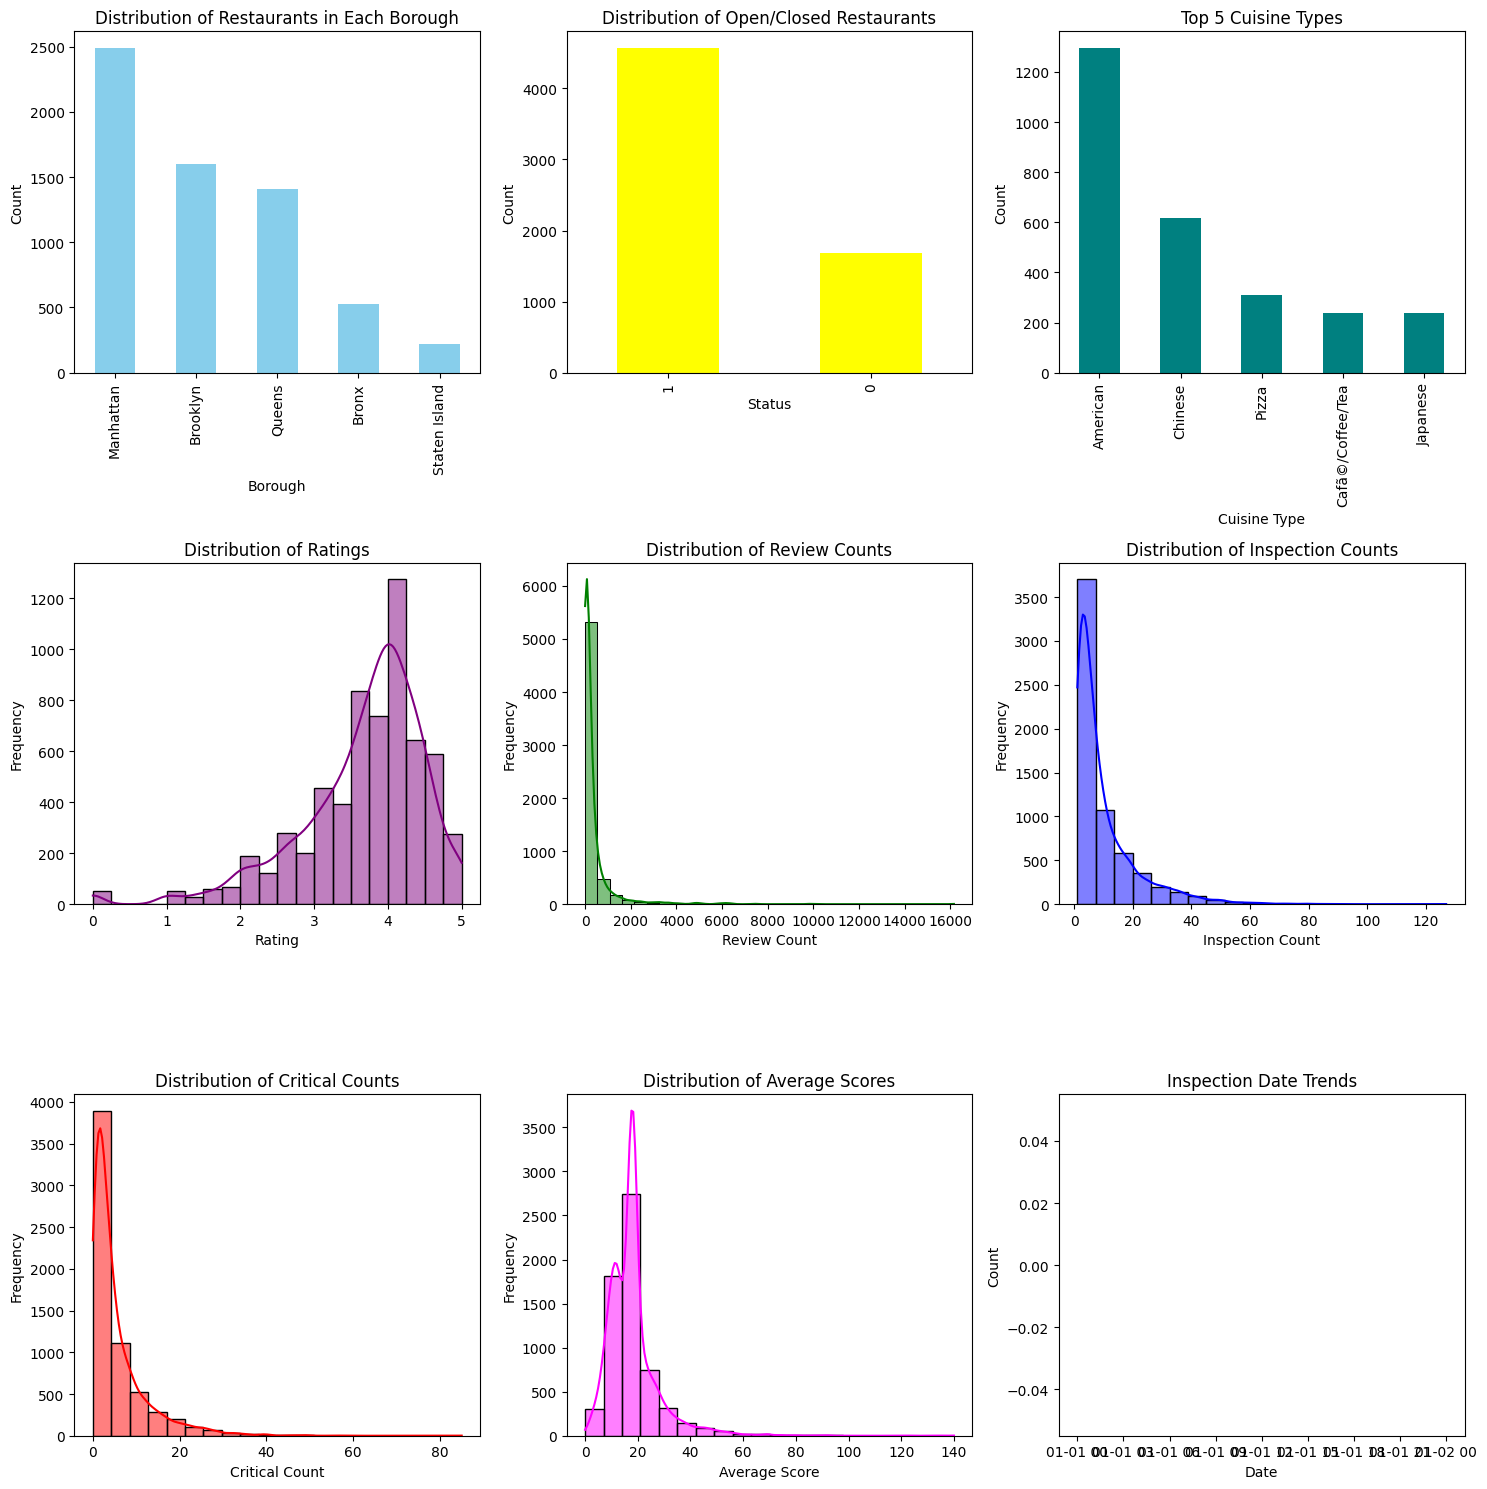

In [ ]:
# univariate
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# 1. distribution of boroughs
df['boro'].value_counts().plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Restaurants in Each Borough')
axes[0].set_xlabel('Borough')
axes[0].set_ylabel('Count')

# 2. distribution of open/closed
df['status'].value_counts().plot(kind='bar', color='yellow', ax=axes[1])
axes[1].set_title('Distribution of Open/Closed Restaurants')
axes[1].set_xlabel('Status')
axes[1].set_ylabel('Count')

# 3. top 5 cuisine types
top_cuisines = df['cuisine'].value_counts().head(5)
top_cuisines.plot(kind='bar', color='teal', ax=axes[2])
axes[2].set_title('Top 5 Cuisine Types')
axes[2].set_xlabel('Cuisine Type')
axes[2].set_ylabel('Count')

# 4. distribution of ratings
sns.histplot(df['rating'], kde=True, color='purple', bins=20, ax=axes[3])
axes[3].set_title('Distribution of Ratings')
axes[3].set_xlabel('Rating')
axes[3].set_ylabel('Frequency')

# 5. distribution of review counts
sns.histplot(df['review_count'], kde=True, color='green', bins=30, ax=axes[4])
axes[4].set_title('Distribution of Review Counts')
axes[4].set_xlabel('Review Count')
axes[4].set_ylabel('Frequency')

# 6. distribution of inspection counts
sns.histplot(df['inspection_count'], kde=True, color='blue', bins=20, ax=axes[5])
axes[5].set_title('Distribution of Inspection Counts')
axes[5].set_xlabel('Inspection Count')
axes[5].set_ylabel('Frequency')

# 7. distribution of critical counts
sns.histplot(df['critical_count'], kde=True, color='red', bins=20, ax=axes[6])
axes[6].set_title('Distribution of Critical Counts')
axes[6].set_xlabel('Critical Count')
axes[6].set_ylabel('Frequency')

# 8. distribution of average scores
sns.histplot(df['avg_score'].dropna(), kde=True, color='magenta', bins=20, ax=axes[7])
axes[7].set_title('Distribution of Average Scores')
axes[7].set_xlabel('Average Score')
axes[7].set_ylabel('Frequency')

# 9. inspection date trends
df['inspection_date_flat'] = pd.to_datetime(df['inspection_date'].explode(), errors='coerce')
inspection_trends = df['inspection_date_flat'].value_counts().sort_index()
axes[8].plot(inspection_trends.index, inspection_trends.values)
axes[8].set_title('Inspection Date Trends')
axes[8].set_xlabel('Date')
axes[8].set_ylabel('Count')

plt.tight_layout()
plt.show()

<ipython-input-244-17a5013d0908>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='price', y='rating', palette='coolwarm', ax=axes[0])


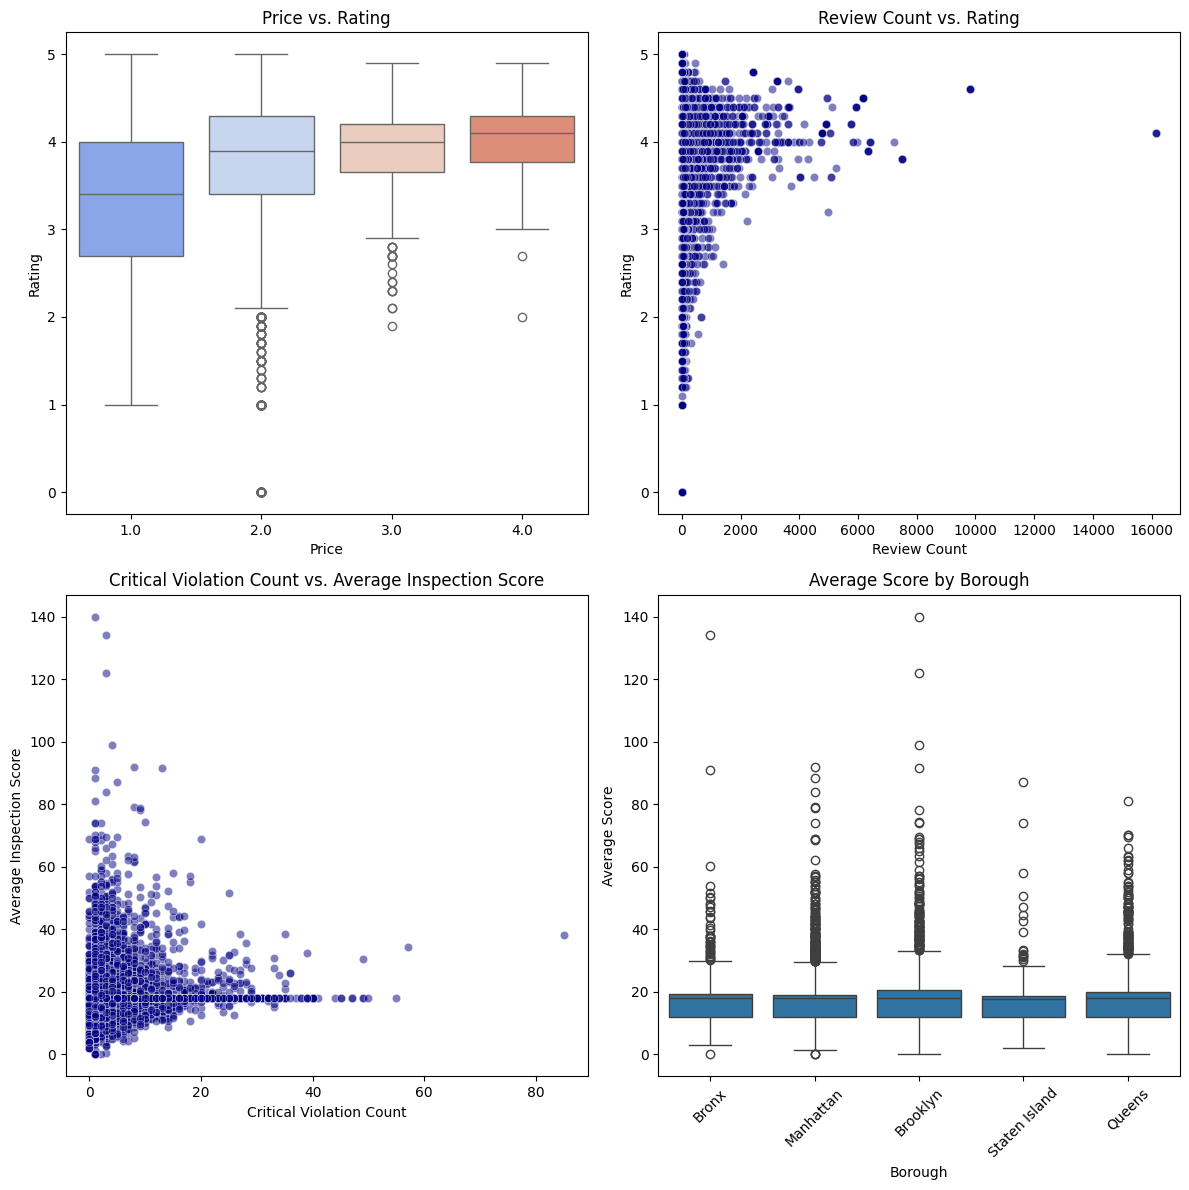

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

# 1. Price vs. Rating
sns.boxplot(data=df, x='price', y='rating', palette='coolwarm', ax=axes[0])
axes[0].set_title('Price vs. Rating')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Rating')

# 2. Review Count vs. Rating
sns.scatterplot(data=df, x='review_count', y='rating', alpha=0.5, color='navy', ax=axes[1])
axes[1].set_title('Review Count vs. Rating')
axes[1].set_xlabel('Review Count')
axes[1].set_ylabel('Rating')

# 3. Critical Count vs. Average Score
sns.scatterplot(data=df, x='critical_count', y='avg_score', alpha=0.5, color='navy', ax=axes[2])
axes[2].set_title('Critical Violation Count vs. Average Inspection Score')
axes[2].set_xlabel('Critical Violation Count')
axes[2].set_ylabel('Average Inspection Score')

# 4. Borough vs. Average Score
sns.boxplot(x='boro', y='avg_score', data=df, ax=axes[3])
axes[3].set_title('Average Score by Borough')
axes[3].set_xlabel('Borough')
axes[3].set_ylabel('Average Score')
axes[3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


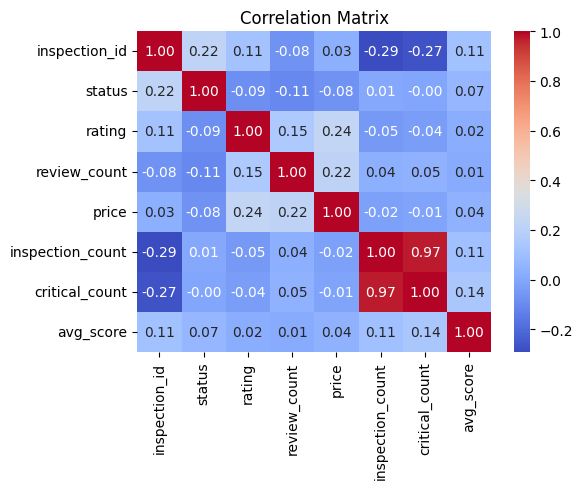

In [ ]:
# correlation matrix
fig, ax = plt.subplots(figsize=(6, 5))

sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=ax)
ax.set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

                  status
price          -0.075442
review_count   -0.107228
critical_count -0.004182
avg_score       0.066428
rating         -0.085961


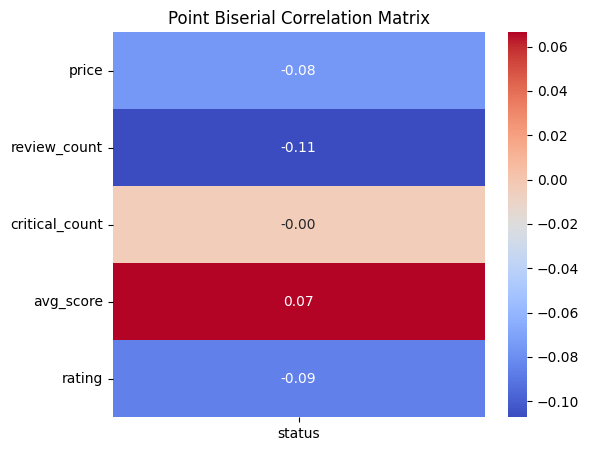

In [ ]:
# biserial correlation matrix

def point_biserial_correlation_matrix(df, binary_col, continuous_cols):
    correlations = {}
    for col in continuous_cols:
        if col != binary_col:  # Skip the binary column itself
            corr, _ = pointbiserialr(df[binary_col], df[col])
            correlations[col] = corr
    return pd.DataFrame(correlations, index=[binary_col]).T

binary_column = 'status'
continuous_columns = ['price', 'review_count', 'critical_count', 'avg_score', 'rating']
correlation_matrix = point_biserial_correlation_matrix(df, binary_column, continuous_columns)
print(correlation_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Point Biserial Correlation Matrix')
plt.show()

check if numerical features are normally distributed

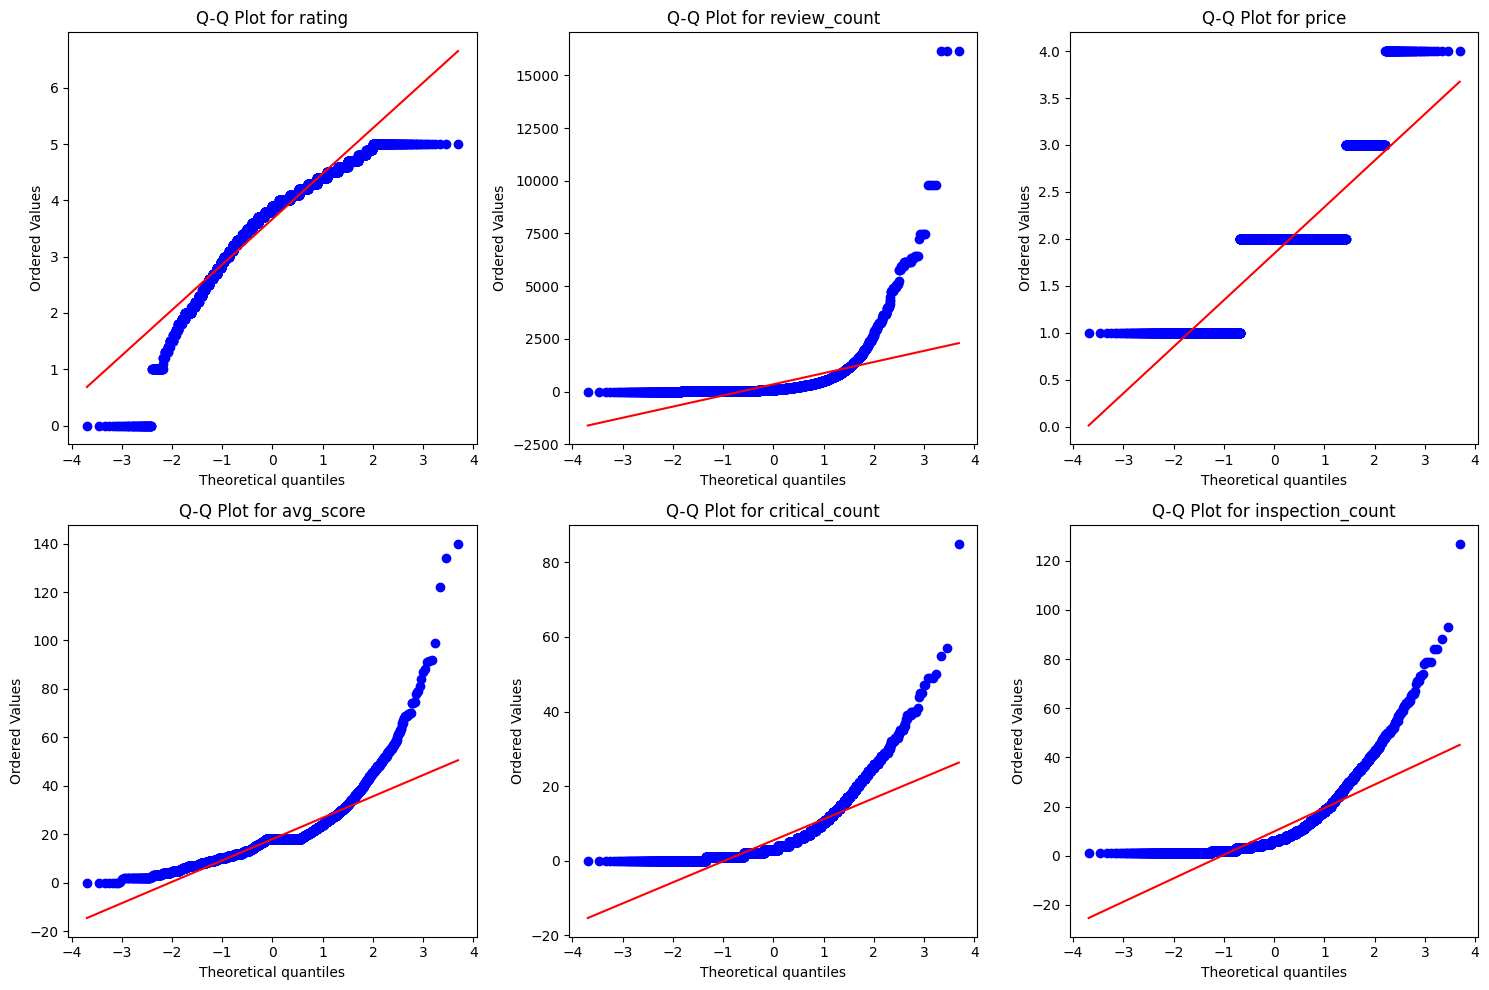

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats

numerical_features = ['rating', 'review_count', 'price', 'avg_score', 'critical_count', 'inspection_count']

num_features = len(numerical_features)
rows = (num_features + 2 - 1) // 3
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))  # Adjust height for better spacing
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    # Q-Q Plot
    stats.probplot(df[feature].dropna(), dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q Plot for {feature}')
for j in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Modeling (composite)

In [286]:
# reusable code

features = ['boro', 'rating', 'review_count', 'price','critical_count', 'avg_score']
X = df[features]
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# preprocessing pipeline
numerical_features = ['rating', 'review_count','price','critical_count', 'avg_score']
categorical_features = ['boro']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


# optionally, apply SMOTE for oversampling on the training set (try removing it too)
smote = SMOTE(sampling_strategy='minority',random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

              precision    recall  f1-score   support

           0       0.31      0.57      0.40       337
           1       0.77      0.54      0.63       914

    accuracy                           0.55      1251
   macro avg       0.54      0.55      0.52      1251
weighted avg       0.65      0.55      0.57      1251

ROC-AUC: 0.5531
Confusion Matrix:
[[191 146]
 [421 493]]


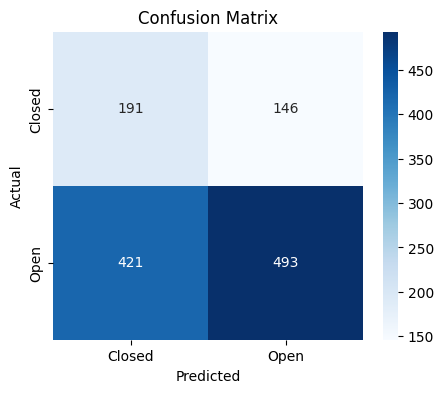

In [287]:
# LOGISTIC REGRESSION

logreg = LogisticRegression(class_weight='balanced', random_state=42)

# train
logreg.fit(X_train_resampled, y_train_resampled)

# predict and evaluate
y_pred = logreg.predict(X_test_processed)
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc:.4f}")

# confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Closed", "Open"], yticklabels=["Closed", "Open"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.32      0.61      0.42       337
           1       0.78      0.52      0.62       914

    accuracy                           0.54      1251
   macro avg       0.55      0.56      0.52      1251
weighted avg       0.66      0.54      0.57      1251

ROC-AUC: 0.5624
Confusion Matrix:
[[205 132]
 [442 472]]


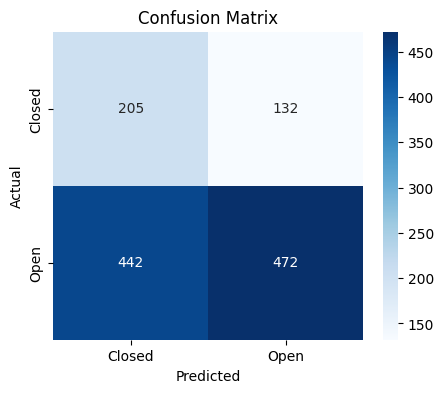

In [279]:
# hyperparameter tuning - grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1','l2'],
    'solver': ['liblinear']
}
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced',random_state=42), param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)
print(grid_search.best_params_)

# use best estimator for predictions
best_log = grid_search.best_estimator_
y_pred_best = best_log.predict(X_test_processed)

# evaluate
print(classification_report(y_test, y_pred_best))

roc_auc = roc_auc_score(y_test, y_pred_best)
print(f"ROC-AUC: {roc_auc:.4f}")

# confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Closed", "Open"], yticklabels=["Closed", "Open"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.01}
Best CV Score: 0.5853818417987996
              precision    recall  f1-score   support

           0       0.30      0.55      0.39       337
           1       0.76      0.53      0.63       914

    accuracy                           0.54      1251
   macro avg       0.53      0.54      0.51      1251
weighted avg       0.64      0.54      0.56      1251

ROC-AUC: 0.5414
Confusion Matrix:
[[185 152]
 [426 488]]


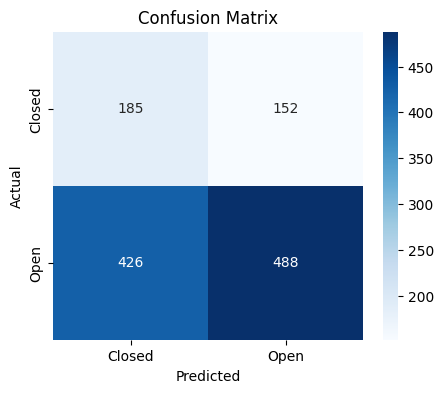

In [320]:
# hyperparameter tuning- randomized search

param_distributions = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

random_search = RandomizedSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42),
    param_distributions=param_distributions,
    n_iter=50,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_resampled, y_train_resampled)

# best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)

# again, use best estimator
best_log = random_search.best_estimator_
y_pred_best = best_log.predict(X_test_processed)

# evaluate again
print(classification_report(y_test, y_pred_best))

roc_auc = roc_auc_score(y_test, y_pred_best)
print(f"ROC-AUC: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred_best)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Closed", "Open"], yticklabels=["Closed", "Open"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.

              precision    recall  f1-score   support

           0       0.34      0.58      0.42       337
           1       0.79      0.58      0.67       914

    accuracy                           0.58      1251
   macro avg       0.56      0.58      0.55      1251
weighted avg       0.67      0.58      0.60      1251

ROC-AUC: 0.5783
Confusion Matrix:
[[194 143]
 [383 531]]


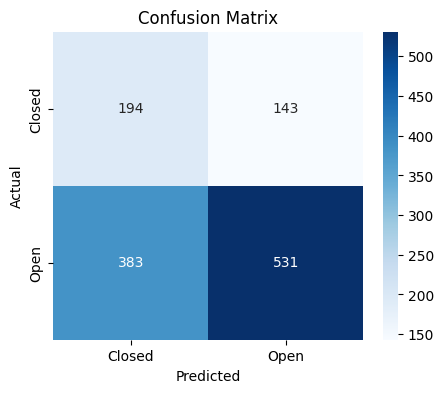

In [280]:
# BALANCED RANDOM FOREST

brf = BalancedRandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
brf.fit(X_train_resampled, y_train_resampled)

brf_pipeline=Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', brf)
])

# train and predict
brf_pipeline.fit(X_train, y_train)
y_pred = brf_pipeline.predict(X_test)

# evaluate
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Closed", "Open"], yticklabels=["Closed", "Open"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


{'classifier__bootstrap': True, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.28      0.99      0.44       337
           1       0.95      0.09      0.16       914

    accuracy                           0.33      1251
   macro avg       0.62      0.54      0.30      1251
weighted avg       0.77      0.33      0.23      1251

ROC-AUC: 0.5783
Confusion Matrix:
[[194 143]
 [383 531]]


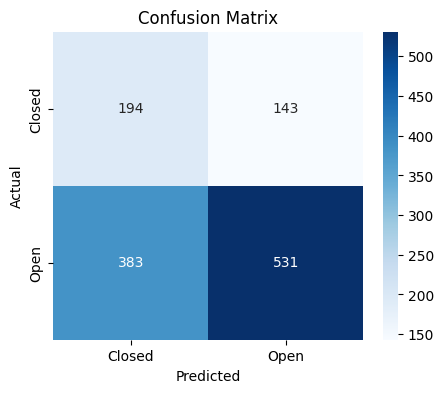

In [278]:
# hyperparameter tuning - grid search

param_grid = {
    'classifier__bootstrap':[True],
    'classifier__n_estimators': [100,150,200],
    'classifier__max_depth': [5,10,15],
    'classifier__min_samples_split': [2,5],
    'classifier__min_samples_leaf': [1, 5,10]
}

grid_search = GridSearchCV(brf_pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

best_brf = grid_search.best_estimator_
y_pred_best = best_brf.predict(X_test)

print(classification_report(y_test, y_pred_best))
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Closed", "Open"], yticklabels=["Closed", "Open"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


{'classifier__n_estimators': 150, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 10, 'classifier__max_depth': 15, 'classifier__bootstrap': True}
              precision    recall  f1-score   support

           0       0.29      0.96      0.44       337
           1       0.90      0.12      0.22       914

    accuracy                           0.35      1251
   macro avg       0.59      0.54      0.33      1251
weighted avg       0.73      0.35      0.28      1251

ROC-AUC: 0.5915
Confusion Matrix:
[[197 140]
 [367 547]]


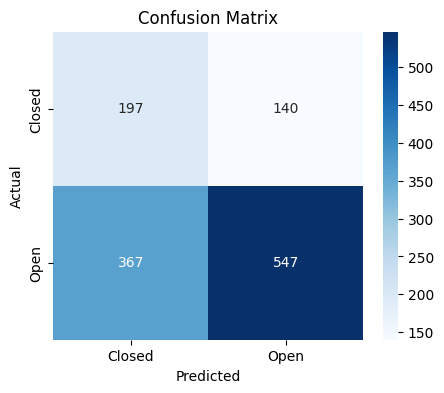

In [275]:
# hyperparameter tuning - random search

param_grid = {
    'classifier__bootstrap':[True],
    'classifier__n_estimators': [100,150,200],
    'classifier__max_depth': [5,10,15],
    'classifier__min_samples_split': [2,5],
    'classifier__min_samples_leaf': [1, 5,10]
}

random_search = RandomizedSearchCV(brf_pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

random_search.fit(X_train, y_train)

print(random_search.best_params_)

best_brf = random_search.best_estimator_
y_pred_best = best_brf.predict(X_test)

print(classification_report(y_test, y_pred_best))
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Closed", "Open"], yticklabels=["Closed", "Open"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Modeling (review data)

In [321]:
# reusable code

features = ['boro','rating', 'review_count']
X = df[features]
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_features = ['rating', 'review_count']
categorical_features = ['boro']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

smote = SMOTE(sampling_strategy='minority',random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

              precision    recall  f1-score   support

           0       0.33      0.56      0.42       337
           1       0.78      0.58      0.66       914

    accuracy                           0.57      1251
   macro avg       0.56      0.57      0.54      1251
weighted avg       0.66      0.57      0.60      1251

ROC-AUC: 0.5702
Confusion Matrix:
[[190 147]
 [387 527]]


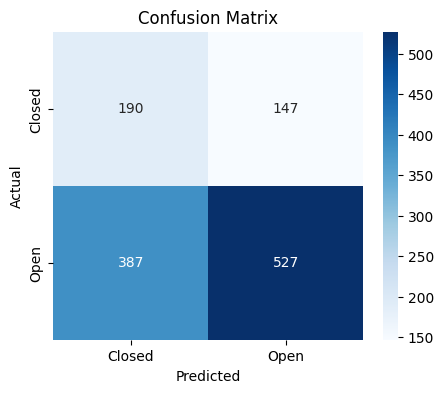

In [322]:
# LOGISTIC REGRESSION

logreg = LogisticRegression(class_weight='balanced', random_state=42)

logreg.fit(X_train_resampled, y_train_resampled)

y_pred = logreg.predict(X_test_processed)
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Closed", "Open"], yticklabels=["Closed", "Open"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.30      0.55      0.39       337
           1       0.76      0.53      0.63       914

    accuracy                           0.54      1251
   macro avg       0.53      0.54      0.51      1251
weighted avg       0.64      0.54      0.56      1251

ROC-AUC: 0.5414
Confusion Matrix:
[[185 152]
 [426 488]]


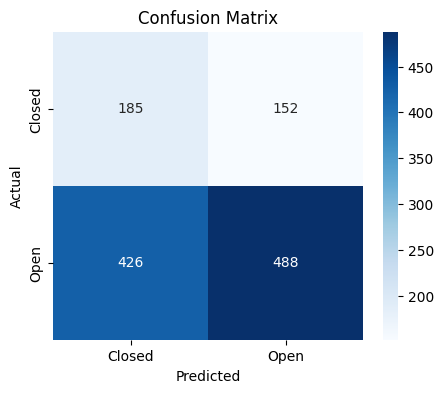

In [323]:
# hyperparameter tuning - grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1],
    'penalty': ['l1','l2'],
    'solver': ['liblinear']
}
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced',random_state=42), param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)
print(grid_search.best_params_)

best_log = grid_search.best_estimator_
y_pred_best = best_log.predict(X_test_processed)

print(classification_report(y_test, y_pred_best))

roc_auc = roc_auc_score(y_test, y_pred_best)
print(f"ROC-AUC: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred_best)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Closed", "Open"], yticklabels=["Closed", "Open"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.01}
Best CV Score: 0.5853818417987996
              precision    recall  f1-score   support

           0       0.30      0.55      0.39       337
           1       0.76      0.53      0.63       914

    accuracy                           0.54      1251
   macro avg       0.53      0.54      0.51      1251
weighted avg       0.64      0.54      0.56      1251

ROC-AUC: 0.5414
Confusion Matrix:
[[185 152]
 [426 488]]


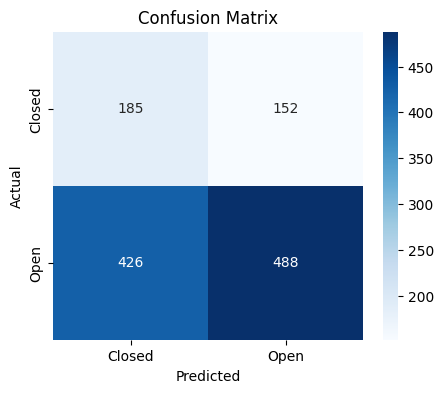

In [324]:
# hyperparameter tuning- randomized search

param_distributions = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

random_search = RandomizedSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42),
    param_distributions=param_distributions,
    n_iter=50,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_resampled, y_train_resampled)

print("Best Parameters:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)

best_log = random_search.best_estimator_
y_pred_best = best_log.predict(X_test_processed)

print(classification_report(y_test, y_pred_best))

roc_auc = roc_auc_score(y_test, y_pred_best)
print(f"ROC-AUC: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred_best)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Closed", "Open"], yticklabels=["Closed", "Open"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.

              precision    recall  f1-score   support

           0       0.30      0.58      0.40       337
           1       0.76      0.51      0.61       914

    accuracy                           0.53      1251
   macro avg       0.53      0.54      0.50      1251
weighted avg       0.64      0.53      0.55      1251

ROC-AUC: 0.5422
Confusion Matrix:
[[194 143]
 [449 465]]


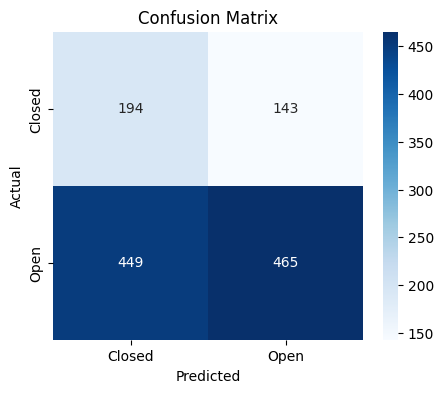

In [329]:
# BALANCED RANDOM FOREST
brf = BalancedRandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
brf.fit(X_train_resampled, y_train_resampled)

brf_pipeline=Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', brf)
])

brf_pipeline.fit(X_train, y_train)

y_pred = brf_pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Closed", "Open"], yticklabels=["Closed", "Open"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


{'classifier__bootstrap': True, 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.27      0.99      0.43       337
           1       0.83      0.01      0.02       914

    accuracy                           0.28      1251
   macro avg       0.55      0.50      0.22      1251
weighted avg       0.68      0.28      0.13      1251

ROC-AUC: 0.5422
Confusion Matrix:
[[194 143]
 [449 465]]


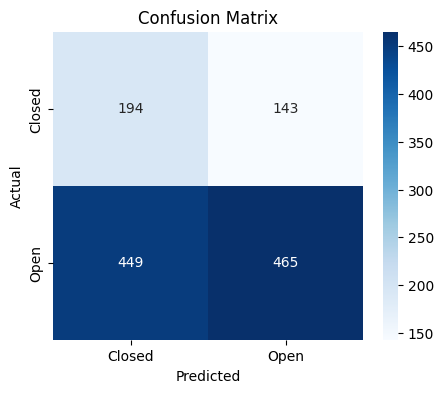

In [327]:
# hyperparameter tuning - grid search

param_grid = {
    'classifier__bootstrap':[True],
    'classifier__n_estimators': [100,150,200],
    'classifier__max_depth': [5,10,15],
    'classifier__min_samples_split': [2,5],
    'classifier__min_samples_leaf': [1, 5,10]
}

grid_search = GridSearchCV(brf_pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

best_brf = grid_search.best_estimator_
y_pred_best = best_brf.predict(X_test)

print(classification_report(y_test, y_pred_best))
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Closed", "Open"], yticklabels=["Closed", "Open"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


{'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 10, 'classifier__max_depth': 5, 'classifier__bootstrap': True}
              precision    recall  f1-score   support

           0       0.27      0.99      0.43       337
           1       0.90      0.02      0.04       914

    accuracy                           0.28      1251
   macro avg       0.59      0.51      0.23      1251
weighted avg       0.73      0.28      0.14      1251

ROC-AUC: 0.5422
Confusion Matrix:
[[194 143]
 [449 465]]


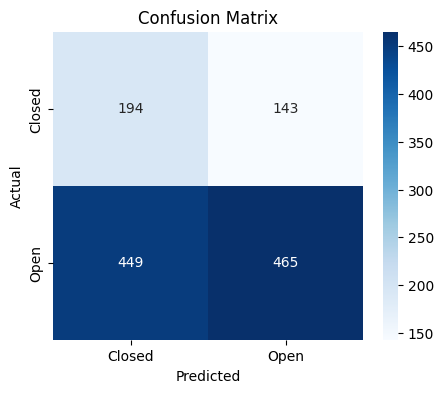

In [326]:
# hyperparameter tuning - random search

param_grid = {
    'classifier__bootstrap':[True],
    'classifier__n_estimators': [100,150,200],
    'classifier__max_depth': [5,10,15],
    'classifier__min_samples_split': [2,5],
    'classifier__min_samples_leaf': [1, 5,10]
}

random_search = RandomizedSearchCV(brf_pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

random_search.fit(X_train, y_train)

print(random_search.best_params_)

best_brf = random_search.best_estimator_
y_pred_best = best_brf.predict(X_test)

print(classification_report(y_test, y_pred_best))
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Closed", "Open"], yticklabels=["Closed", "Open"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Modeling (inspection data)

In [336]:
# reusable code

features = ['boro','avg_score','critical_count']
X = df[features]
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_features = ['avg_score','critical_count']
categorical_features = ['boro']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

smote = SMOTE(sampling_strategy='minority',random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

              precision    recall  f1-score   support

           0       0.29      0.60      0.39       337
           1       0.76      0.46      0.57       914

    accuracy                           0.50      1251
   macro avg       0.52      0.53      0.48      1251
weighted avg       0.63      0.50      0.52      1251

ROC-AUC: 0.5300
Confusion Matrix:
[[202 135]
 [493 421]]


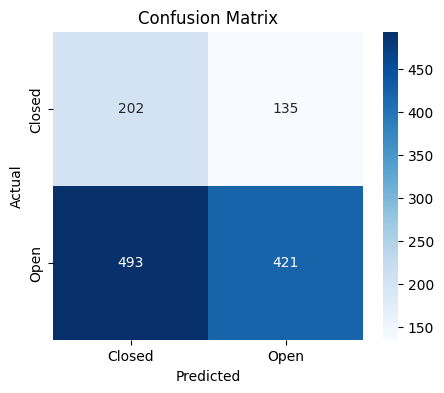

In [337]:
# LOGISTIC REGRESSION

logreg = LogisticRegression(class_weight='balanced', random_state=42)

logreg.fit(X_train_resampled, y_train_resampled)

y_pred = logreg.predict(X_test_processed)
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Closed", "Open"], yticklabels=["Closed", "Open"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.29      0.60      0.39       337
           1       0.76      0.46      0.57       914

    accuracy                           0.50      1251
   macro avg       0.52      0.53      0.48      1251
weighted avg       0.63      0.50      0.52      1251

ROC-AUC: 0.5300
Confusion Matrix:
[[202 135]
 [493 421]]


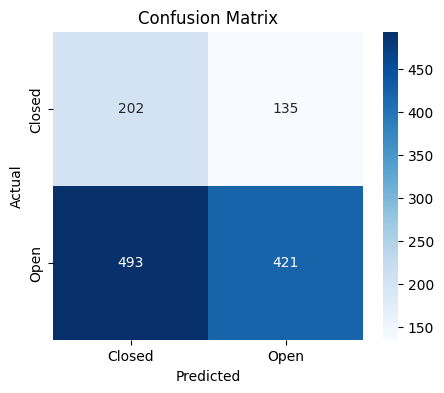

In [338]:
# hyperparameter tuning - grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1],
    'penalty': ['l1','l2'],
    'solver': ['liblinear']
}
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced',random_state=42), param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)
print(grid_search.best_params_)

best_log = grid_search.best_estimator_
y_pred_best = best_log.predict(X_test_processed)

print(classification_report(y_test, y_pred_best))

roc_auc = roc_auc_score(y_test, y_pred_best)
print(f"ROC-AUC: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred_best)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Closed", "Open"], yticklabels=["Closed", "Open"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.

              precision    recall  f1-score   support

           0       0.29      0.72      0.41       337
           1       0.77      0.35      0.49       914

    accuracy                           0.45      1251
   macro avg       0.53      0.53      0.45      1251
weighted avg       0.64      0.45      0.47      1251

ROC-AUC: 0.5348
Confusion Matrix:
[[241  96]
 [590 324]]


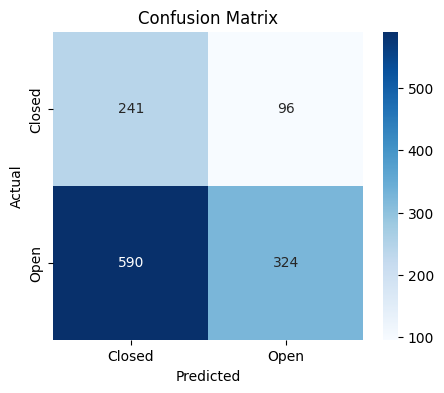

In [341]:
# BALANCED RANDOM FOREST
brf = BalancedRandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
brf.fit(X_train_resampled, y_train_resampled)

brf_pipeline=Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', brf)
])

brf_pipeline.fit(X_train, y_train)

y_pred = brf_pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Closed", "Open"], yticklabels=["Closed", "Open"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


{'classifier__bootstrap': True, 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.27      0.99      0.43       337
           1       0.92      0.02      0.05       914

    accuracy                           0.29      1251
   macro avg       0.59      0.51      0.24      1251
weighted avg       0.74      0.29      0.15      1251

ROC-AUC: 0.5348
Confusion Matrix:
[[241  96]
 [590 324]]


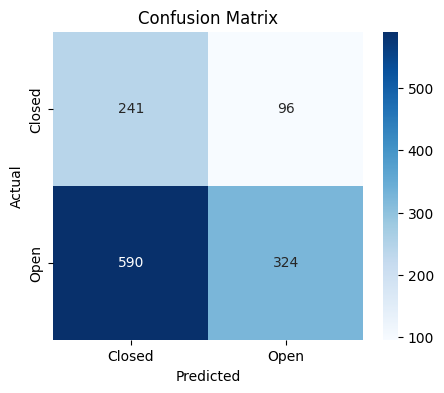

In [342]:
# hyperparameter tuning - grid search

param_grid = {
    'classifier__bootstrap':[True],
    'classifier__n_estimators': [100,150,200],
    'classifier__max_depth': [5,10,15],
    'classifier__min_samples_split': [2,5],
    'classifier__min_samples_leaf': [1, 5,10]
}

grid_search = GridSearchCV(brf_pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

best_brf = grid_search.best_estimator_
y_pred_best = best_brf.predict(X_test)

print(classification_report(y_test, y_pred_best))
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Closed", "Open"], yticklabels=["Closed", "Open"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


{'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 5, 'classifier__bootstrap': True}
              precision    recall  f1-score   support

           0       0.27      0.99      0.43       337
           1       0.92      0.02      0.05       914

    accuracy                           0.29      1251
   macro avg       0.59      0.51      0.24      1251
weighted avg       0.74      0.29      0.15      1251

ROC-AUC: 0.5348
Confusion Matrix:
[[241  96]
 [590 324]]


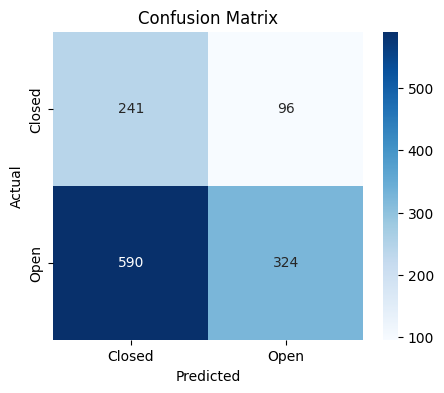

In [343]:
# hyperparameter tuning - random search

param_grid = {
    'classifier__bootstrap':[True],
    'classifier__n_estimators': [100,150,200],
    'classifier__max_depth': [5,10,15],
    'classifier__min_samples_split': [2,5],
    'classifier__min_samples_leaf': [1, 5,10]
}

random_search = RandomizedSearchCV(brf_pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

random_search.fit(X_train, y_train)

print(random_search.best_params_)

best_brf = random_search.best_estimator_
y_pred_best = best_brf.predict(X_test)

print(classification_report(y_test, y_pred_best))
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Closed", "Open"], yticklabels=["Closed", "Open"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Modeling (violation description, just for fun)

In [ ]:
df['violation_description'][0]

["Live Roaches Present In Facility'S Food And/Or Non-Food Areas.",
 'Non-Food Contact Surface Improperly Constructed. Unacceptable Material Used. Non-Food Contact Surface Or Equipment Improperly Maintained And/Or Not Properly Sealed, Raised, Spaced Or Movable To Allow Accessibility For Cleaning On All Sides, Above And Underneath The Unit.',
 'Facility Not Vermin Proof. Harborage Or Conditions Conducive To Attracting Vermin To The Premises And/Or Allowing Vermin To Exist.',
 'Cold Food Item Held Above 41Âº F (Smoked Fish And Reduced Oxygen Packaged Foods Above 38 Âºf) Except During Necessary Preparation.',
 'Facility Not Vermin Proof. Harborage Or Conditions Conducive To Attracting Vermin To The Premises And/Or Allowing Vermin To Exist.',
 "Live Roaches Present In Facility'S Food And/Or Non-Food Areas.",
 "Evidence Of Mice Or Live Mice Present In Facility'S Food And/Or Non-Food Areas.",
 "Live Roaches Present In Facility'S Food And/Or Non-Food Areas.",
 'Facility Not Vermin Proof. Harbo

In [ ]:
!pip install nltk scikit-learn matplotlib

              precision    recall  f1-score   support

      Closed     0.6569    0.7953    0.7195       337
        Open     0.9181    0.8468    0.8810       914

    accuracy                         0.8329      1251
   macro avg     0.7875    0.8210    0.8003      1251
weighted avg     0.8478    0.8329    0.8375      1251

Logistic Regression Classification Report:
              precision    recall  f1-score   support

      Closed     0.6569    0.7953    0.7195       337
        Open     0.9181    0.8468    0.8810       914

    accuracy                         0.8329      1251
   macro avg     0.7875    0.8210    0.8003      1251
weighted avg     0.8478    0.8329    0.8375      1251

Naive Bayes Classification Report:
              precision    recall  f1-score   support

      Closed     0.6233    0.9525    0.7535       337
        Open     0.9783    0.7877    0.8727       914

    accuracy                         0.8321      1251
   macro avg     0.8008    0.8701    0.8131      1

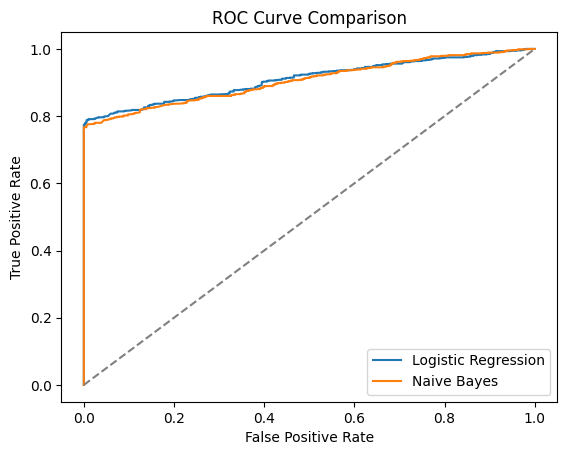

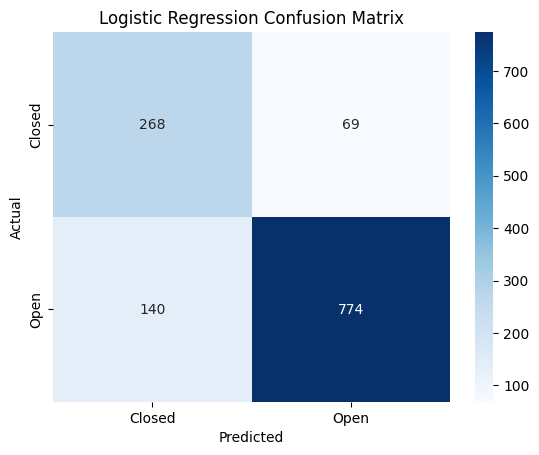

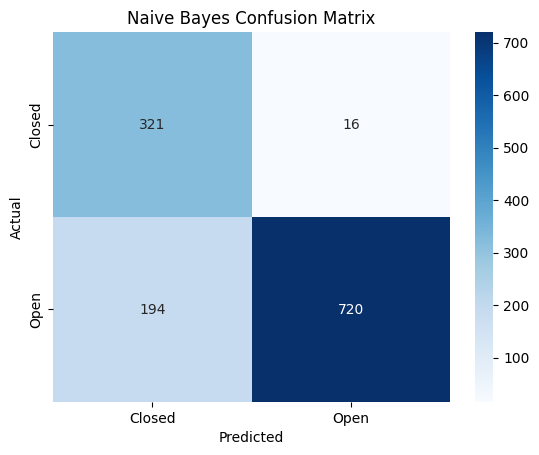

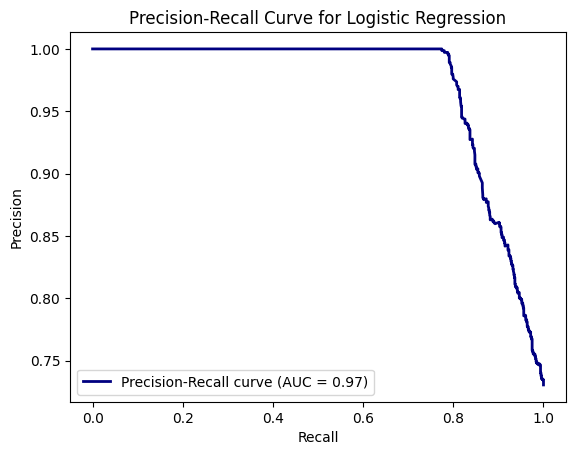

Top words likely indicating 'Open':
hot food: -0.19982032665034466
food protected: -0.18276090062817843
maintained: -0.15986847156982126
facility: -0.15773712016143612
present: -0.15478946359017523
present facility: -0.14268246319268005
improperly: -0.129310126397006
improperly maintained: -0.11863461059413147
maintained properly: -0.11863461059413147
constructed unacceptable: -0.11863461059413147
surface improperly: -0.1162452169099416
equipment improperly: -0.11532832393868257
utensil: -0.11348317335505922
material used: -0.11293893025449171
improperly constructed: -0.11293893025449171
held supervisor: -0.11058048826753816
certificate held: -0.11058048826753816
constructed: -0.10235119912848403
occurred food: -0.09992228935765608
mice present: -0.09152751925153972


Top words likely indicating 'Closed':
rodents insects: 0.1491865404190016
rodents: 0.1491865404190016
conducive rodents: 0.1491865404190016
establishment free: 0.1491865404190016
free harborage: 0.1491865404190016
clean p

In [347]:
print(classification_report(y_test, y_pred_log_reg, target_names=['Closed', 'Open'], digits=4))
# to clean and preprocess text
def review_to_words(raw_review):
    if isinstance(raw_review, list):
        raw_review = ' '.join(raw_review)
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review)
    raw_words = letters_only.lower().split()
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in raw_words if not w in stops]
    return ' '.join(meaningful_words)

# predictor and outcome
violation_descriptions = df['violation_description']
clean_descriptions = [review_to_words(review) for review in violation_descriptions]

# feature extraction using CountVectorizer
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 2), min_df=1e-4)
X = vectorizer.fit_transform(clean_descriptions)
y = df['status'].values  # Assuming 'status' contains 'Open'/'Closed' labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

chi2_values, p_values = chi2(X_train, y_train)
selected_features = np.where(p_values <= 0.05)[0]  # Select features with p-value <= 0.05
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# --- Logistic Regression ---
# Logistic Regression Classifier
log_reg_clf = LogisticRegression(C=0.01, max_iter=500)
log_reg_clf.fit(X_train_selected, y_train)

# Logistic Regression Prediction
y_pred_log_reg = log_reg_clf.predict(X_test_selected)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg, target_names=['Closed', 'Open'], digits=4))

# --- Naive Bayes ---
# Naive Bayes Classifier
nb_clf = MultinomialNB()
nb_clf.fit(X_train_selected, y_train)

# Naive Bayes Predictions
y_pred_nb = nb_clf.predict(X_test_selected)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb, target_names=['Closed','Open'], digits=4))

# --- Plot ROC AUC Curves ---
def plot_roc_curve(fpr, tpr, label):
    plt.plot(fpr, tpr, label=label)

# Logistic Regression ROC curve
y_pred_log_reg_prob = log_reg_clf.predict_proba(X_test_selected)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_log_reg_prob)
plot_roc_curve(fpr_lr, tpr_lr, "Logistic Regression")

# Naive Bayes ROC curve
y_pred_nb_prob = nb_clf.predict_proba(X_test_selected)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_nb_prob)
plot_roc_curve(fpr_nb, tpr_nb, "Naive Bayes")

# Plotting the ROC curve
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# --- Visualize Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed', 'Open'], yticklabels=['Closed', 'Open'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Confusion Matrix for Logistic Regression
plot_confusion_matrix(y_test, y_pred_log_reg, "Logistic Regression Confusion Matrix")

# Confusion Matrix for Naive Bayes
plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes Confusion Matrix")

# --- Precision-Recall Curve for Logistic Regression ---
y_pred_prob_log_reg = log_reg_clf.predict_proba(X_test_selected)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_log_reg)
average_precision = average_precision_score(y_test, y_pred_prob_log_reg)

plt.plot(recall, precision, lw=2, color='navy', label='Precision-Recall curve (AUC = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.legend(loc="lower left")
plt.show()

# --- Top Words Analysis for Logistic Regression ---
words = np.array(vectorizer.get_feature_names_out())
word_reduction = words[selected_features]
probs = log_reg_clf.coef_.flatten()

# Top words indicating "Open"
top_open_words = word_reduction[np.argsort(probs)[:20]]
top_open_probs = probs[np.argsort(probs)[:20]]

# Top words indicating "Closed"
top_closed_words = word_reduction[np.argsort(probs)[-20:]]
top_closed_probs = probs[np.argsort(probs)[-20:]]

print("Top words likely indicating 'Open':")
for word, prob in zip(top_open_words, top_open_probs):
    print(f"{word}: {prob}")
print('\n')
print("Top words likely indicating 'Closed':")
for word, prob in zip(top_closed_words, top_closed_probs):
    print(f"{word}: {prob}")


In [ ]:
print(f"Number of features: {X.shape[1]}")


Number of features: 4698
